# LNP Model


This is a JAX implementation of a linear-nonlinear-Poisson (LNP) model (see [Pillow _et al._ (2008)](https://www.nature.com/articles/nature07140)) used to fit two-photon zebrafish calcium fluorescence data.


### Parameters

The hyperparameters are
* $N$: Number of neurons.
* $M$: Number of time steps in the input.
* $dh$: Number of time steps to consider for convolution.
* $ds$: Number of stimuli
* $dt$: Time per step (seconds).

The weights are

* $\theta_h$ ($N \times dh$ matrix) is the temporal coupling weight.
* $\theta_w$ ($N \times N$ matrix) is the coupling between neurons.
* $\theta_b$ ($N \times 1$ matrix) is the base firing rate for each cell.
* $\theta_s$ ($N \times ds$ matrix) is the cell's response to each stimulus.

The inputs are:
* $y$ is an $N \times M$ matrix that contains spiking rate.
* $s$ is a $ds \times M$ matrix that contains the stimulus data.

### Model

Let $h(y)$ be a sliding window convolution between $\theta_h$ and $y$. 
$$
h(y) = \theta_h * y(:,i).
$$

Then, the predicted activity $\hat{r}$ (a vector of length $N$) for the next time step is
$$
\hat{r}(y, s) = dt \times \exp\left\{\theta_ks + h(y) + \theta_wy + \theta_b \right\}. \\
$$

The log-likelihood is
$$
\ell(y, \hat{r}) = \frac{1}{MN} \left( \hat{r} - \sum_{i=0}^N y_i \odot \log(\hat{r}) \right).
$$

### Implementation

The model is coded for the just-in-time (JIT) compiler of JAX for speed and automatic differentiation.

The compiler needs to know the exact dimensions of all matrices that are passed into each function. Direct substitutions are not allowed as it disrupts the model differentiability.

Any changes in input dimensions will lead to a recompilation which destroys all speed benefit. Hence, the hyperparameter $M$ or $M_{\text{lim}}$ is assumed to be fixed. As the number of detected neurons do increase through the run, $N_{\text{lim}}$ will automatically increase by 2-fold when the dimensions of $y$ and $s$ exceed $N_{\text{lim}}$. Extra space in the weight matrices $\theta$ are padded with 0.

### Data

Download `tbif_batch_for_analysis.pk` from the `improv Data Sharing` folder. This is a pickled file of `y` and `s` processed through `CaImAN` from `08-17-14_1437_F1_6dpfCOMPLETESET_WB_overclimbing_z-1.tbif`.

Using CaImAn from `pearsonlab/CaImAn`, branch `lite`, commit `c28094ea5b3becd2818a4e0677e5fd9b08a1e6b4`. The parameters are as followed.
'fr': 2,
'decay_time': 0.8,
'gSig': (3,3),
'p': 1,
'min_SNR': 1.5,
'rval_thr': 1,
'ds_factor': 1,
'nb': 2,
'motion_correct': True,
'init_batch': 100,
'init_method': 'bare',
'normalize': True,
'sniper_mode': True,
'K': 10,
'epochs': 1,
'max_shifts_online': np.ceil(10).astype('int'),
'pw_rigid': False,
'dist_shape_update': True,
'show_movie': False,
'update_freq': 50,
'minibatch_shape': 100,
'output': 'outputEstimates'}

### Optimizer Comparison

In [2]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from compare_opt import CompareOpt

sns.set()

params = {'dh': 10, 'ds': 8, 'dt': 0.5, 'n': 0, 'N_lim': 800}  # M_lim depends on online/offline.
lr = 1e-5
optimizers = [
    {'name': 'sgd', 'step_size': lr},
    {'name': 'sgd', 'step_size': lr, 'offline': True},
    {'name': 'nesterov', 'step_size': lr, 'mass': 0.9},
    {'name': 'nesterov', 'step_size': lr, 'mass': 0.9, 'offline': True},
    {'name': 'adam', 'step_size': lr},
    {'name': 'adam', 'step_size': lr, 'offline': True},
    {'name': 'adagrad', 'step_size': lr, 'momentum': 0.9},
    {'name': 'adagrad', 'step_size': lr, 'momentum': 0.9, 'offline': True},
    {'name': 'rmsprop', 'step_size': lr},
    {'name': 'rmsprop', 'step_size': lr, 'offline': True},
    {'name': 'rmsprop_momentum', 'step_size': lr},
    {'name': 'rmsprop_momentum', 'step_size': lr, 'offline': True},
]

S, stim = pickle.loads(Path('../twot.pk').read_bytes())
c = CompareOpt(params, S, stim)


0.0

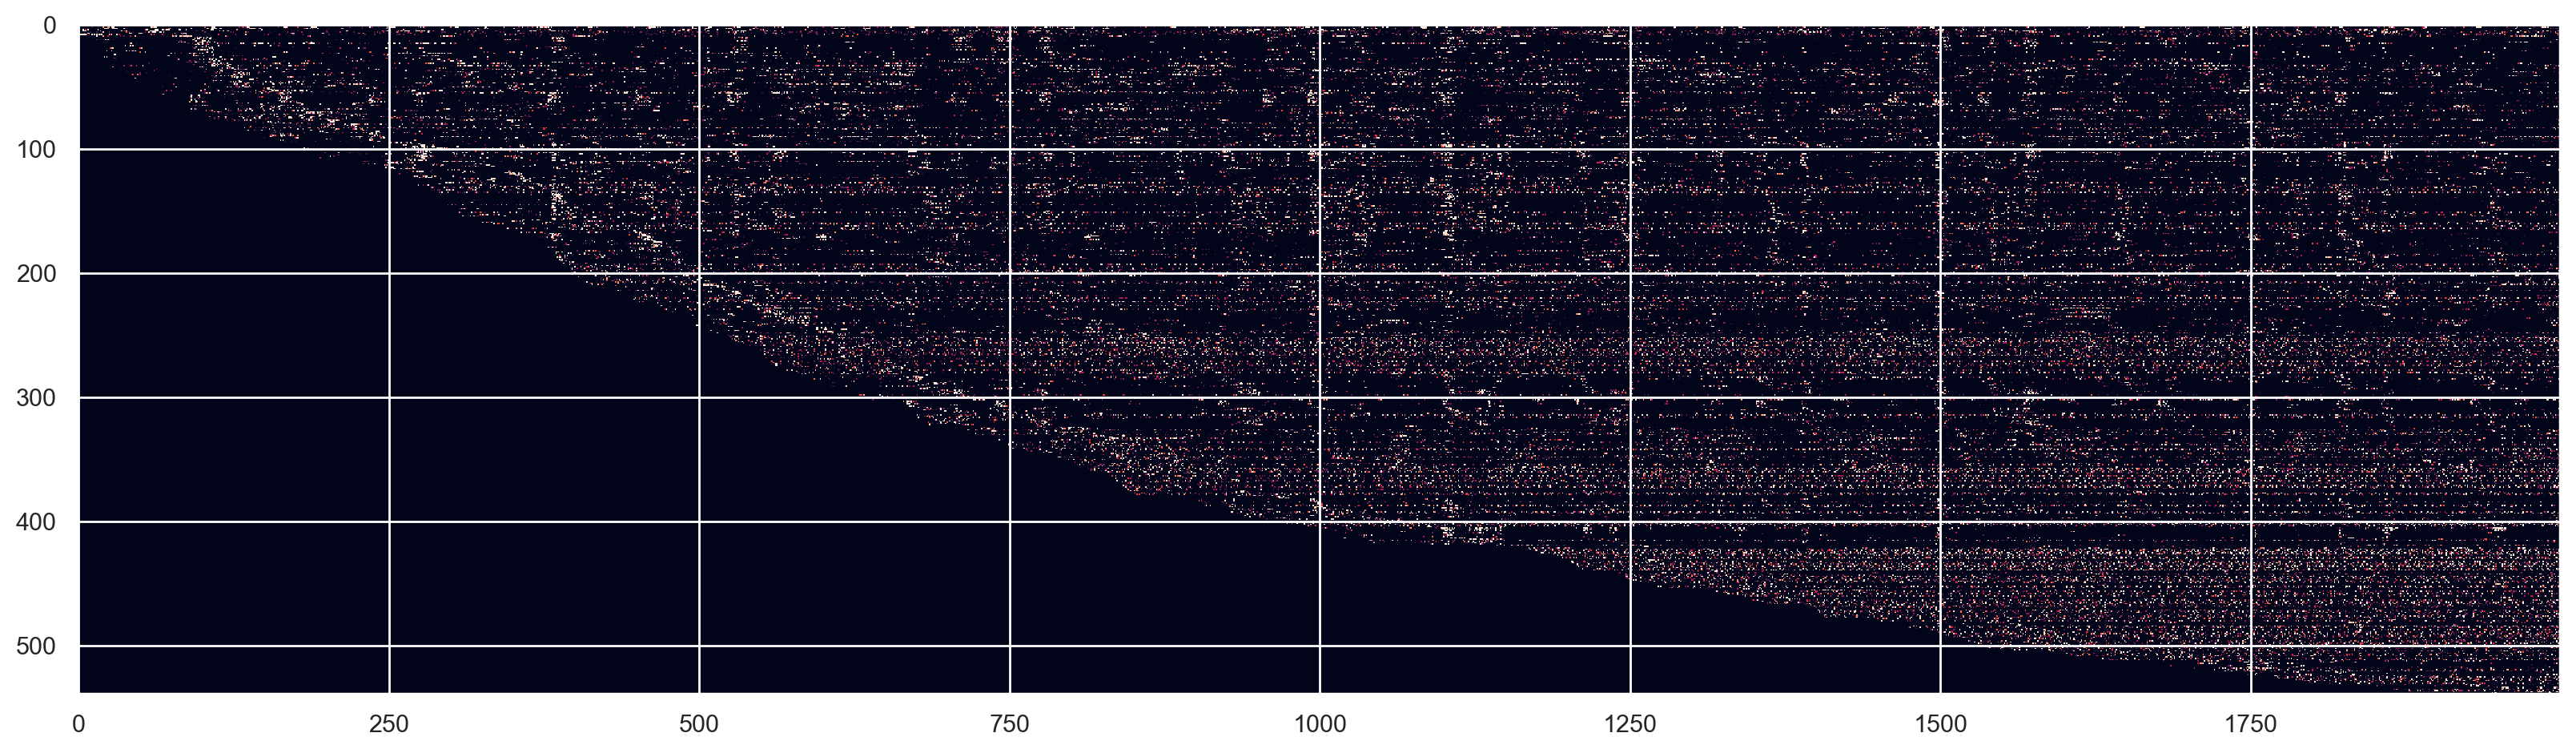

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6), dpi=200)
ax.imshow(S, vmin=0, vmax=1)
np.min(S)

In [2]:
lls = c.run(optimizers, save_grad=False, save_theta=False, use_gpu=True)

Using gpu:0
Optimizer: {'name': 'sgd', 'step_size': 1e-05}
sgd, step: 1000, b_norm: 0.0, ll:0.5672647356987
sgd: 0.004009 s/step
Using gpu:0
Optimizer: {'name': 'sgd', 'step_size': 1e-05}
sgd, step: 1000, b_norm: 0.0, ll:0.5463908910751343
sgd: 0.008913 s/step
Using gpu:0
Optimizer: {'name': 'nesterov', 'step_size': 1e-05, 'mass': 0.9}
nesterov, step: 1000, b_norm: 0.0, ll:0.5504820346832275
nesterov: 0.005748 s/step
Using gpu:0
Optimizer: {'name': 'nesterov', 'step_size': 1e-05, 'mass': 0.9}
nesterov, step: 1000, b_norm: 0.0, ll:0.5461499094963074
nesterov: 0.010706 s/step
Using gpu:0
Optimizer: {'name': 'adam', 'step_size': 1e-05}
adam, step: 1000, b_norm: 0.0, ll:0.3780784010887146
adam: 0.010994 s/step
Using gpu:0
Optimizer: {'name': 'adam', 'step_size': 1e-05}
adam, step: 1000, b_norm: 0.0, ll:0.3428131639957428
adam: 0.014512 s/step
Using gpu:0
Optimizer: {'name': 'adagrad', 'step_size': 1e-05, 'momentum': 0.9}
adagrad, step: 1000, b_norm: 0.0, ll:0.5403826832771301
adagrad: 0.00

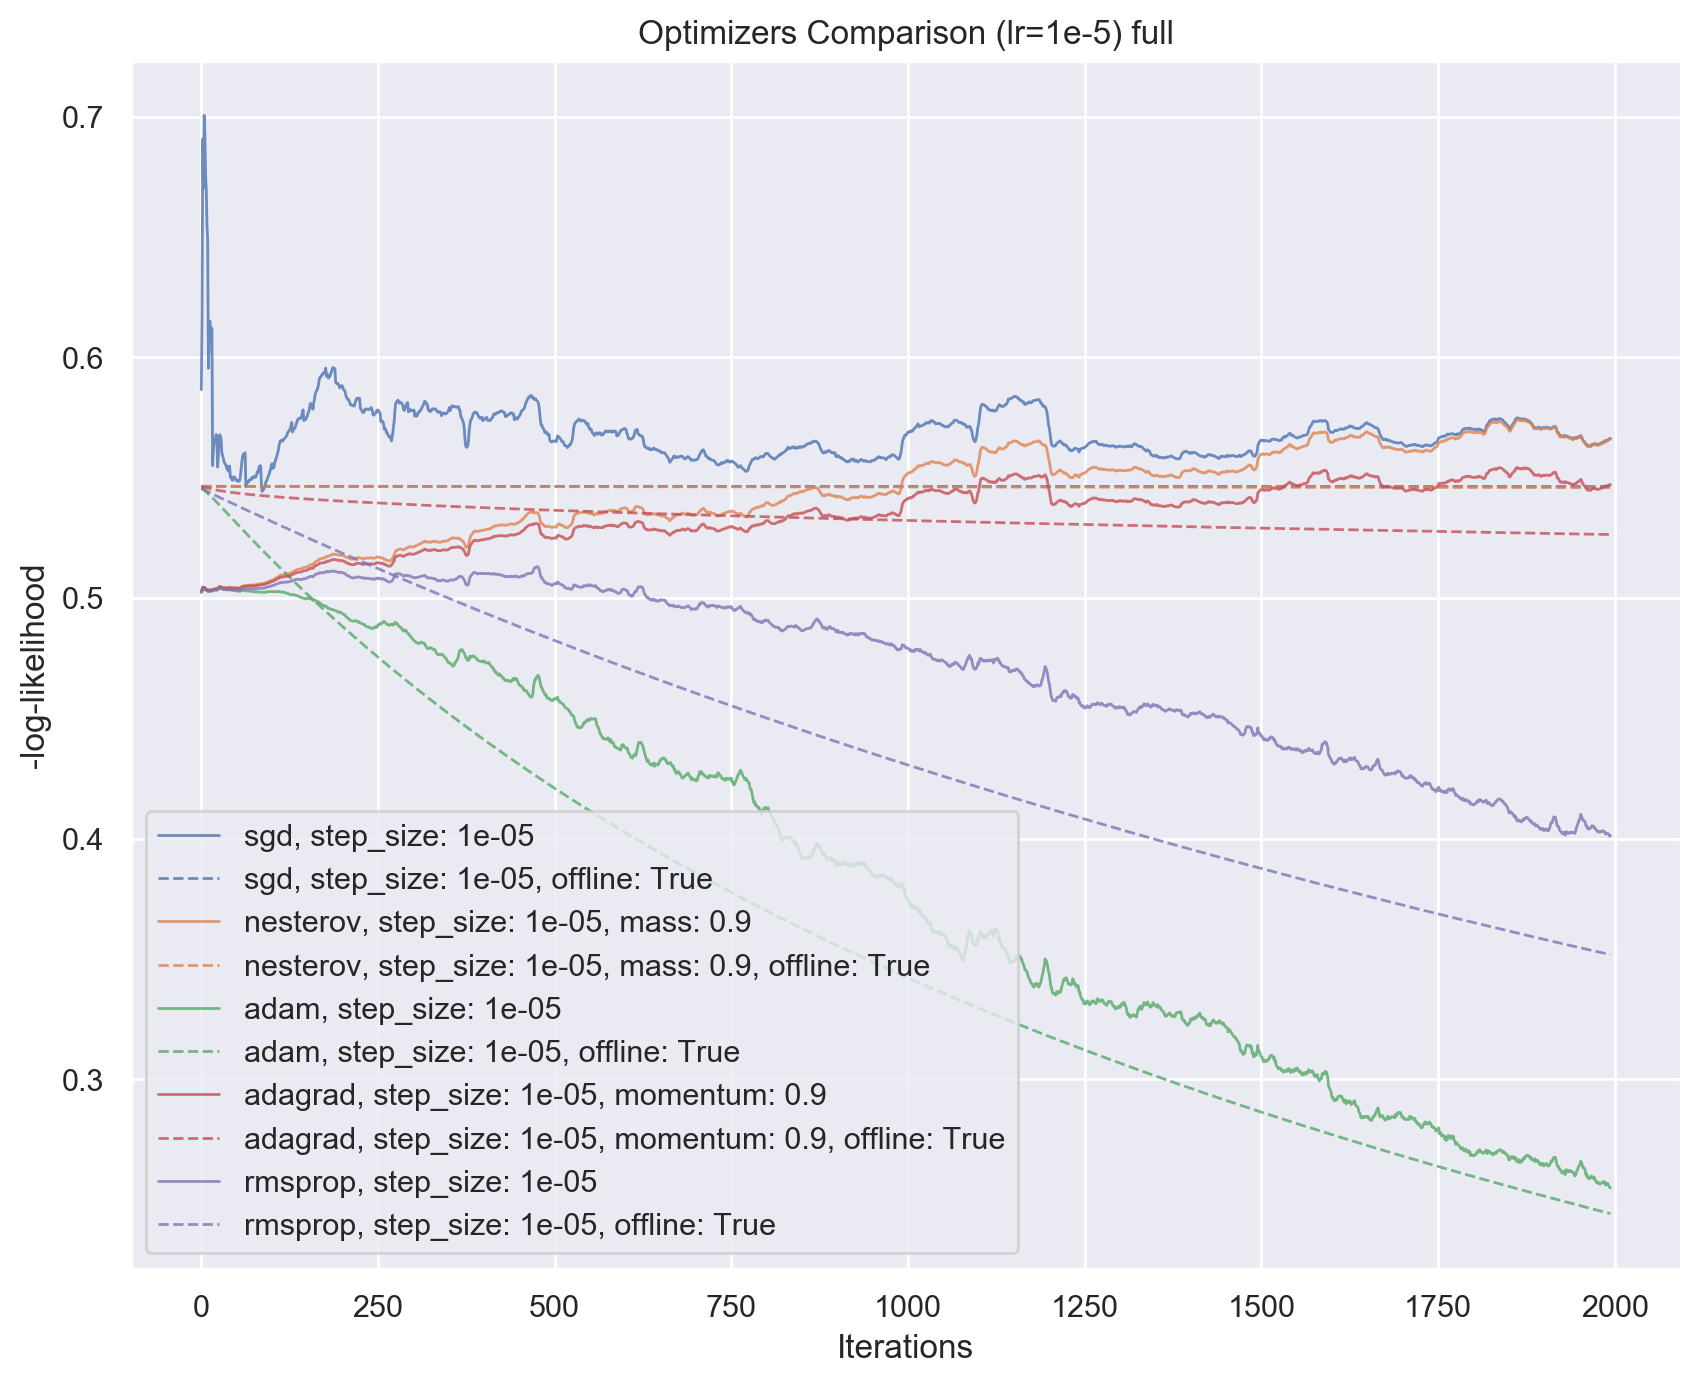

In [3]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
colors = [f'C{i}' for i in range(len(optimizers) // 2 + 1)]
for i, (k, v) in enumerate(lls.items()):
    if 'momentum' not in k:
        if 'offline' in optimizers[i]:
            args = (v[5:], colors[i//2]+'--')
        else:
            args = (v[5:], colors[i//2]+'-')
        ax.plot(*args, linewidth=1, label=", ".join([f'{k}: {v}' for k, v in optimizers[i].items()])[6:], alpha=0.8)

ax.set_xlabel('Iterations')
ax.set_ylabel('-log-likelihood')
ax.set_title('Optimizers Comparison (lr=1e-5) full')
plt.legend()
plt.savefig('optimizer_comp_1e-5 full.png')
plt.show()

import pickle
with open('1e-5.pk', 'wb') as f:
    pickle.dump((optimizers, lls), f)

### Results

Log-likelihood spikes in `rmsprop_momentum` were traced back to the history matrix and seemed to coincide with spikes in neuronal activity.

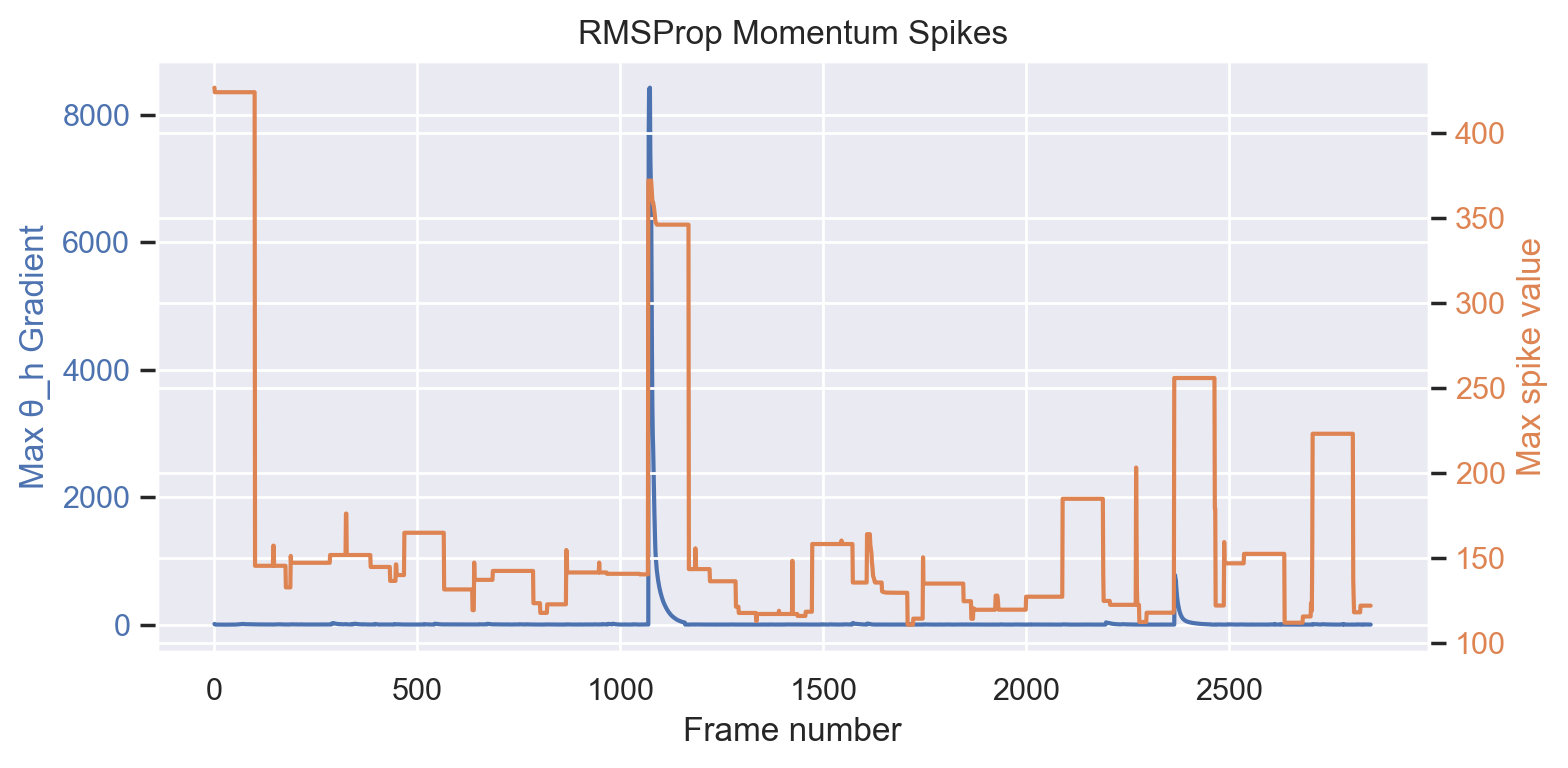

In [5]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
ax.plot(g_h)
ax.set_xlabel('Frame number')
ax.set_ylabel('Max θ_h Gradient', color='C0')
ax.tick_params(axis='y', labelcolor='C0')
ax.set_title('RMSProp Momentum Spikes')

ax2 = ax.twinx()
ax2.plot(y_max, 'C1')
ax2.set_ylabel('Max spike value', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
fig.tight_layout()

### Hyperparameter Optimization

Bayesian hyperparameter optimization based on the Gaussian process is done using the `skopt` package. This is an example for the Nesterov optimizer. The red dashed line indicates the best performer.

In [11]:
import skopt
import skopt.plots

space = [
    skopt.space.Real(1e-6, 1e-4, name='step_size', prior='uniform'),
    skopt.space.Real(0., 1., name='mass', prior='uniform'),
]

results = c.hyper_opt('nesterov', space, n_calls=20)

Using CPU_0
Optimizer: {'name': 'nesterov', 'step_size': 5.9691617204276824e-05, 'mass': 0.8442657485810175}
nesterov, step: 0
nesterov, step: 100
nesterov, step: 200
nesterov, step: 300
nesterov, step: 400
nesterov, step: 500
nesterov, step: 600
nesterov, step: 700
nesterov, step: 800
nesterov, step: 900
nesterov, step: 1000
nesterov, step: 1100
nesterov, step: 1200
nesterov, step: 1300
nesterov, step: 1400
nesterov, step: 1500
nesterov, step: 1600
nesterov, step: 1700
nesterov, step: 1800
nesterov, step: 1900
nesterov, step: 2000
nesterov, step: 2100
nesterov, step: 2200
nesterov, step: 2300
nesterov, step: 2400
nesterov, step: 2500
nesterov, step: 2600
nesterov, step: 2700
nesterov, step: 2800
nesterov: 0.004950 s/step
Using CPU_0
Optimizer: {'name': 'nesterov', 'step_size': 8.593661614465294e-05, 'mass': 0.8472517387841256}
nesterov, step: 0
nesterov, step: 100
nesterov, step: 200
nesterov, step: 300
nesterov, step: 400
nesterov, step: 500
nesterov, step: 600
nesterov, step: 700
ne

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3f007d400>,
      dtype=object)

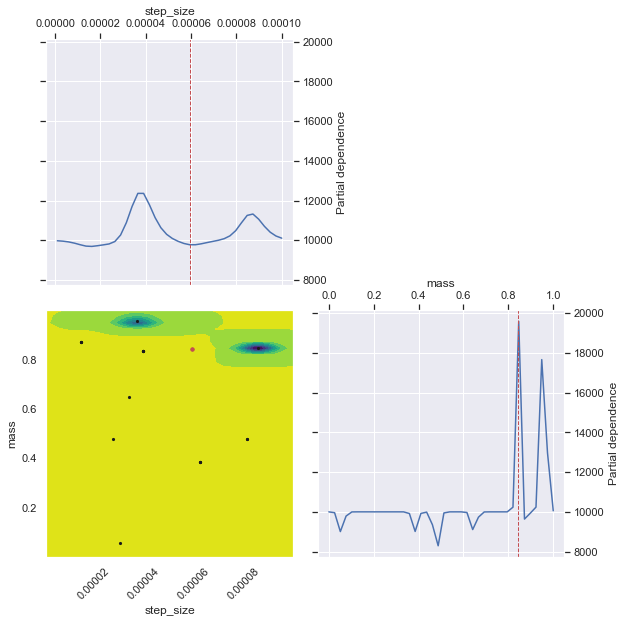

In [13]:
skopt.plots.plot_objective(results, size=4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc46ad42bb0>,
      dtype=object)

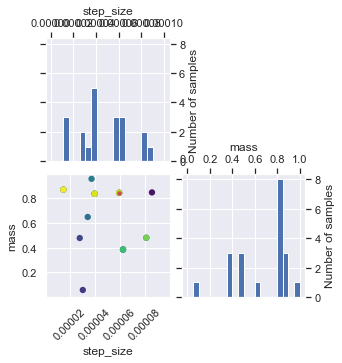

In [16]:
skopt.plots.plot_evaluations(results)

## Synthetic Data

All optimizers apart from the SGD family blew up.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from pathlib import Path

from compare_opt import CompareOpt

sns.set()

params = {'dh': 2, 'ds': 8, 'dt': 0.1, 'n': 0, 'N_lim': 10}  # M_lim depends on online/offline.
lr = 4e-5
optimizers = [
#     {'name': 'sgd', 'step_size': lr},
#     {'name': 'sgd', 'step_size': lr, 'offline': True},
#     {'name': 'momentum', 'step_size': lr, 'mass': 0.9},
#     {'name': 'momentum', 'step_size': lr, 'mass': 0.9, 'offline': True},
#     {'name': 'nesterov', 'step_size': lr, 'mass': 0.9},
#     {'name': 'nesterov', 'step_size': lr, 'mass': 0.9, 'offline': True},
    {'name': 'adam', 'step_size': lr,},
#     {'name': 'adam', 'step_size': lr, 'offline': True},
#     {'name': 'adagrad', 'step_size': lr, 'momentum': 0.9},
#     {'name': 'adagrad', 'step_size': lr, 'momentum': 0.9, 'offline': True},
#     {'name': 'rmsprop', 'step_size': lr},
#     {'name': 'rmsprop', 'step_size': lr, 'offline': True},
#     {'name': 'rmsprop_momentum', 'step_size': lr},
#     {'name': 'rmsprop_momentum', 'step_size': lr, 'offline': True},
]

gnd = pickle.loads(Path('theta_dict.pickle').read_bytes())
S = np.loadtxt('data_sample.txt').astype(np.float32)
stim = np.zeros((params['ds'], S.shape[1]), dtype=np.float32)
c = CompareOpt(params, S, stim)

In [3]:
lls = c.run(optimizers, gnd=gnd)

Using CPU_0
Optimizer: {'name': 'adam', 'step_size': 4e-05}
adam, step: 10, b_norm: 0.07945971168188104, ll:2.094944300698639
adam, step: 20, b_norm: 0.07940158081929226, ll:2.054215788886628
adam, step: 30, b_norm: 0.07936991381286979, ll:2.1303935132446536
adam, step: 40, b_norm: 0.07936265865642905, ll:2.102650503543163
adam, step: 50, b_norm: 0.07937216429454379, ll:2.1242560191644224
adam, step: 60, b_norm: 0.07939387460146954, ll:2.141190083266109
adam, step: 70, b_norm: 0.07942919730960588, ll:2.165569495422186
adam, step: 80, b_norm: 0.07947677490023372, ll:2.1394680468250282
adam, step: 90, b_norm: 0.07953147187112312, ll:2.101365164270289
adam, step: 100, b_norm: 0.0795902908773228, ll:2.107404530059507
adam, step: 110, b_norm: 0.07965374452234435, ll:2.0993823354446657
adam, step: 120, b_norm: 0.07972150812429031, ll:2.0865580588074613
adam, step: 130, b_norm: 0.07979163704350947, ll:2.0837066997512443
adam, step: 140, b_norm: 0.07986188307842192, ll:2.081306530029493
adam, 

KeyboardInterrupt: 

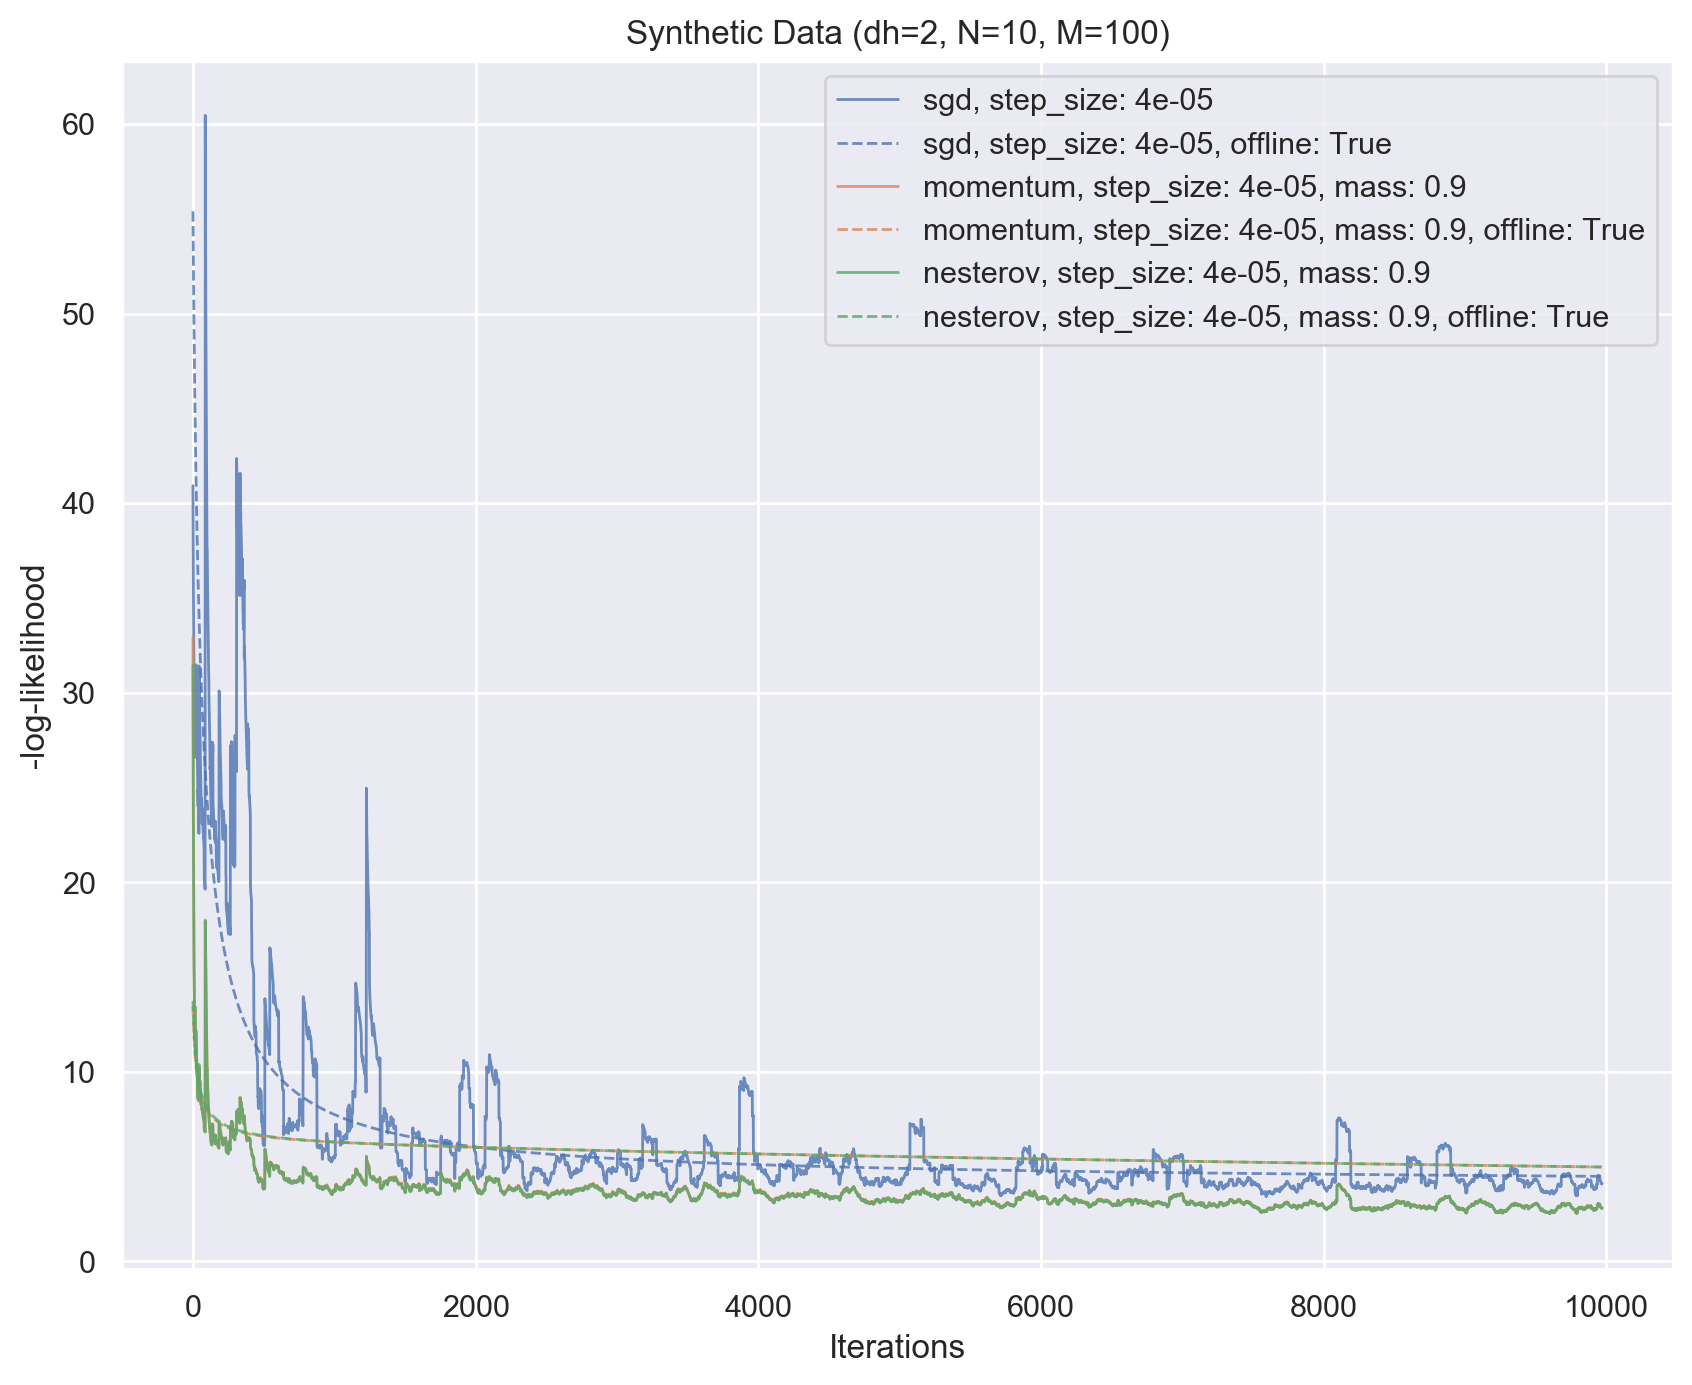

In [38]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
colors = [f'C{i}' for i in range(len(optimizers) // 2 + 1)]
for i, (k, v) in enumerate(lls.items()):
    if 'offline' in optimizers[i]:
        args = (v[30:], colors[i//2]+'--')
    else:
        args = (v[30:], colors[i//2]+'-')
    ax.plot(*args, linewidth=1, label=", ".join([f'{k}: {v}' for k, v in optimizers[i].items()])[6:], alpha=0.8)

ax.set_xlabel('Iterations')
ax.set_ylabel('-log-likelihood')
ax.set_title('Synthetic Data (dh=2, N=10, M=100)')
plt.legend()

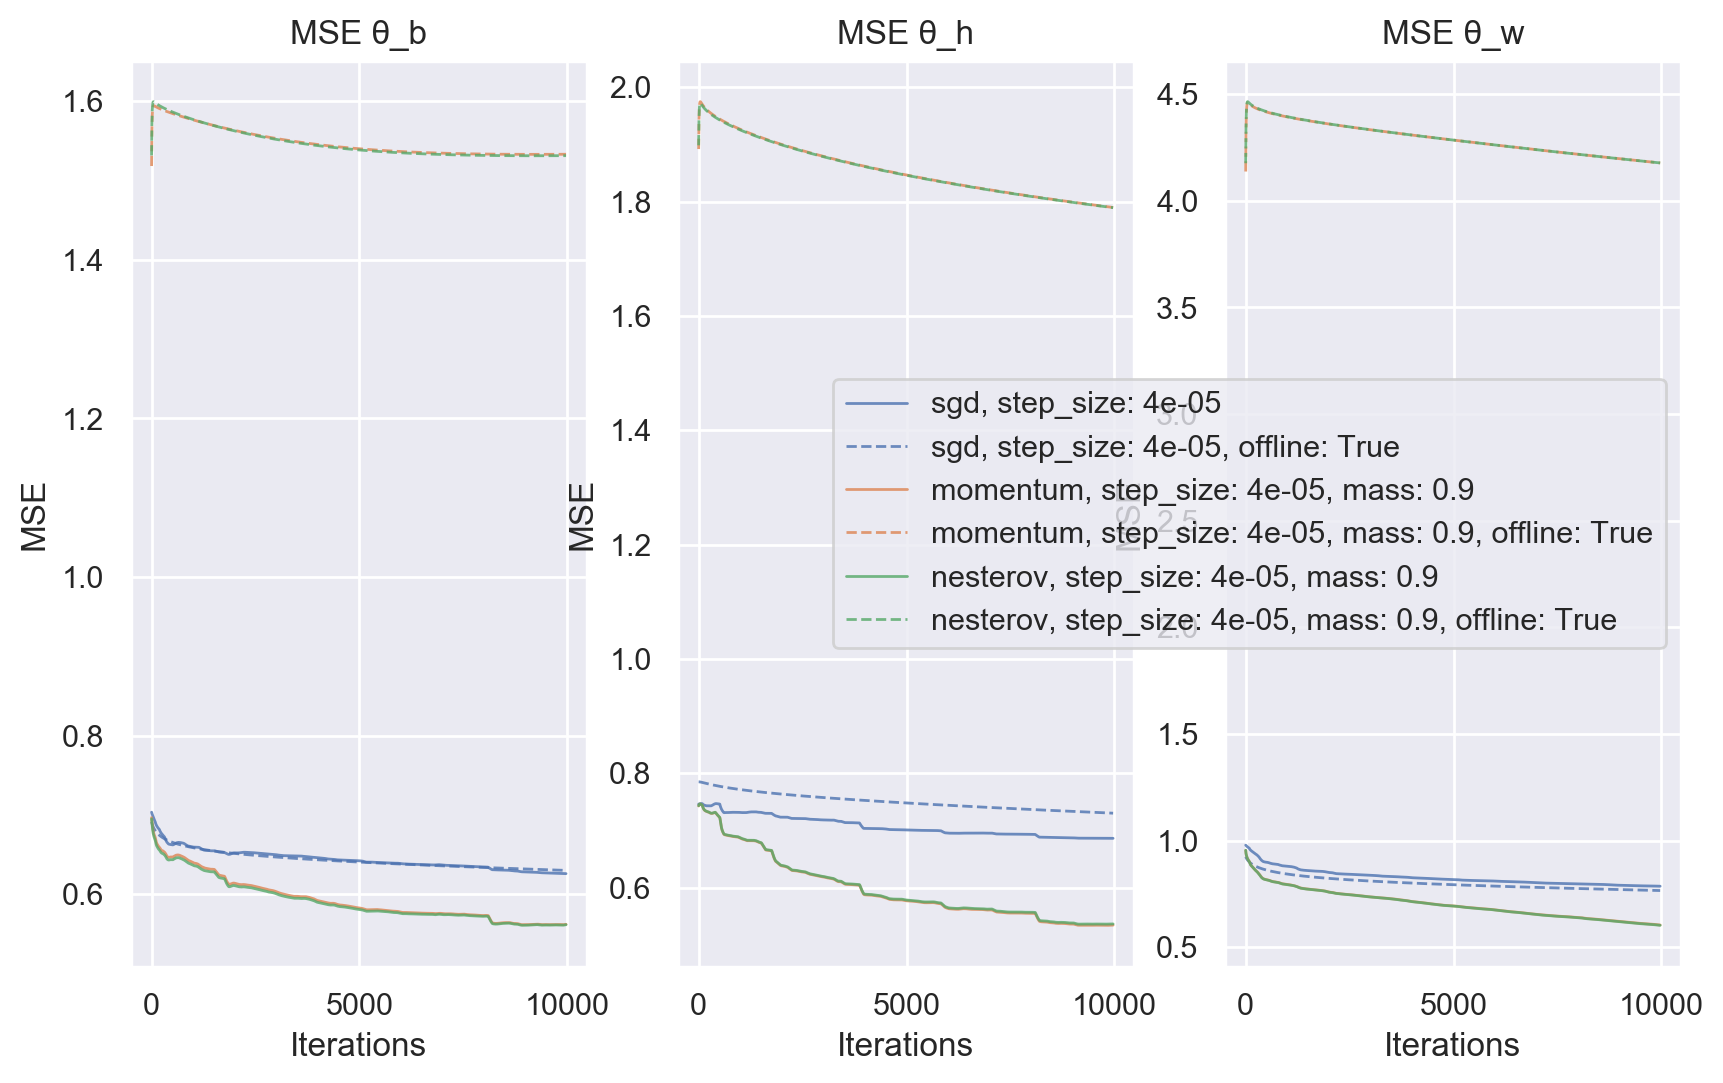

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 6), dpi=200)
axs = np.reshape(ax, 3)
colors = [f'C{i}' for i in range(len(optimizers) // 2 + 1)]
th = ['b', 'h', 'w']


    
for i, (k, v) in enumerate(c.mses.items()):
    for j, name in enumerate(th):
        if 'offline' in optimizers[i]:
            args = (v[30:, j], colors[i//2]+'--')
        else:
            args = (v[30:, j], colors[i//2]+'-')
        axs[j].plot(*args, linewidth=1, label=", ".join([f'{k}: {v}' for k, v in optimizers[i].items()])[6:], alpha=0.8)

for i, ax in enumerate(axs):
    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_title(f'MSE θ_{th[i]}')
    
ax.legend()

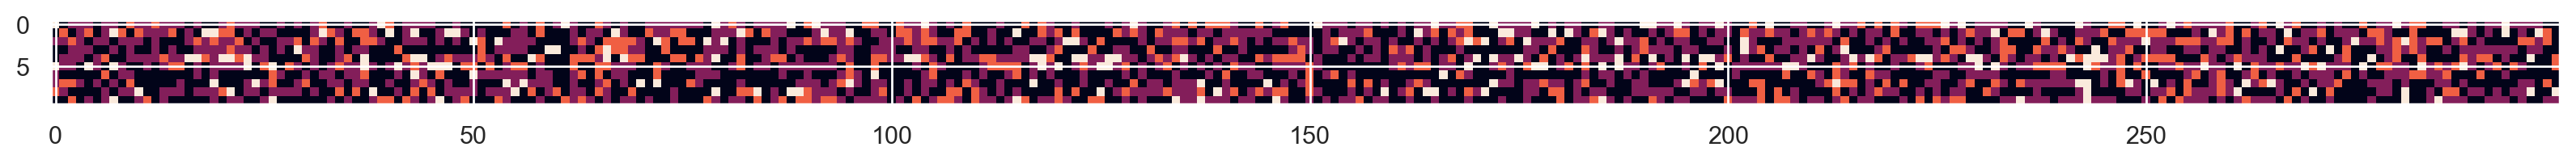

In [19]:
fig, ax = plt.subplots(figsize=(20,6), dpi=200)
ax.imshow(S[:, :300], vmin=0, vmax=3)

In [16]:
S.shape

(10, 10000)